# NIH Chest X-ray Dataset Handling

We shall be sorting the NIH chest X-ray dataset.

In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split

Before dealing with the images we shall handle the csv file which contains the image features.

In [3]:
data_entry_path = os.path.join(os.pardir, "resources/raw_data/nih_chest_xray/data_entry.csv")
df = pd.read_csv(data_entry_path)
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


Our aim is to split the images into their seperate classes so we can easily use them in both GAN and CNN training.

From the `head` above we can see `Finding Labels` can be multi-class. Let's see how many unique values there are.

In [4]:
unique_labels = df['Finding Labels'].unique()
print(f"unique lables: {unique_labels.size}")

unique lables: 836


From the dataset documentation we know there are 14 different disease listing possible (+ `No Finding`) so there are a lot of possible permutations.

Each of the labels in `Finding Labels` is seperated by a `|`, so we can use this delimeter to create features for each disease.

First we will need the new column names.

In [5]:
findings = []

for label in unique_labels:
    split = label.split('|')
    for finding in split:
        if not finding in findings:
            findings.append(finding)

findings

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'No Finding',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

As expected we have 14 diease labels and an additional label for no finding.

Now we can use these to create feature columns.

In [6]:
def get_findings(x):
    x[x['Finding Labels'].split('|')] = 1    
    return x

addcols_df = df.copy()
addcols_df.loc[:, findings] = 0
updated_df = addcols_df.apply(get_findings, axis=1)

Now we can make a copy of the updated dataframe with the new columns.

In [7]:
data_df = updated_df.copy()
data_df[findings].head()

,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Lets look at the instances of each of the new columns.

In [8]:
data_df[findings].sum(axis=0).sort_values(ascending=False)

No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64

No condition seems to be the most often finding. Infiltration, effusion and atelecasis are the most common diseases.

There may be a lot of entries with multiple conditions so lets check this.

In [9]:
instances = data_df[findings].sum(axis=0).sum(axis=0)

print(f"data entries: {df.shape[0]}\ndisease instances: {instances}")

data entries: 112120
disease instances: 141537


From the ~30k additional instances we can tell a lot of entries have mulitple conditions. 

Lets find which conditions occur the most independently of others.

In [10]:
copy_df = data_df.copy()
copy_df['Num_Conditions'] = copy_df[findings].sum(axis=1)
singlecond_df = copy_df[copy_df.Num_Conditions == 1]

singlecond_df[findings].sum(axis=0).sort_values(ascending=False)

No Finding            60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
dtype: int64

As suspected a lot of the entries had multiple conditions. We still have the same top occuring conditions but with around half the instances as before.

Lets look at some of the samples for each condition.

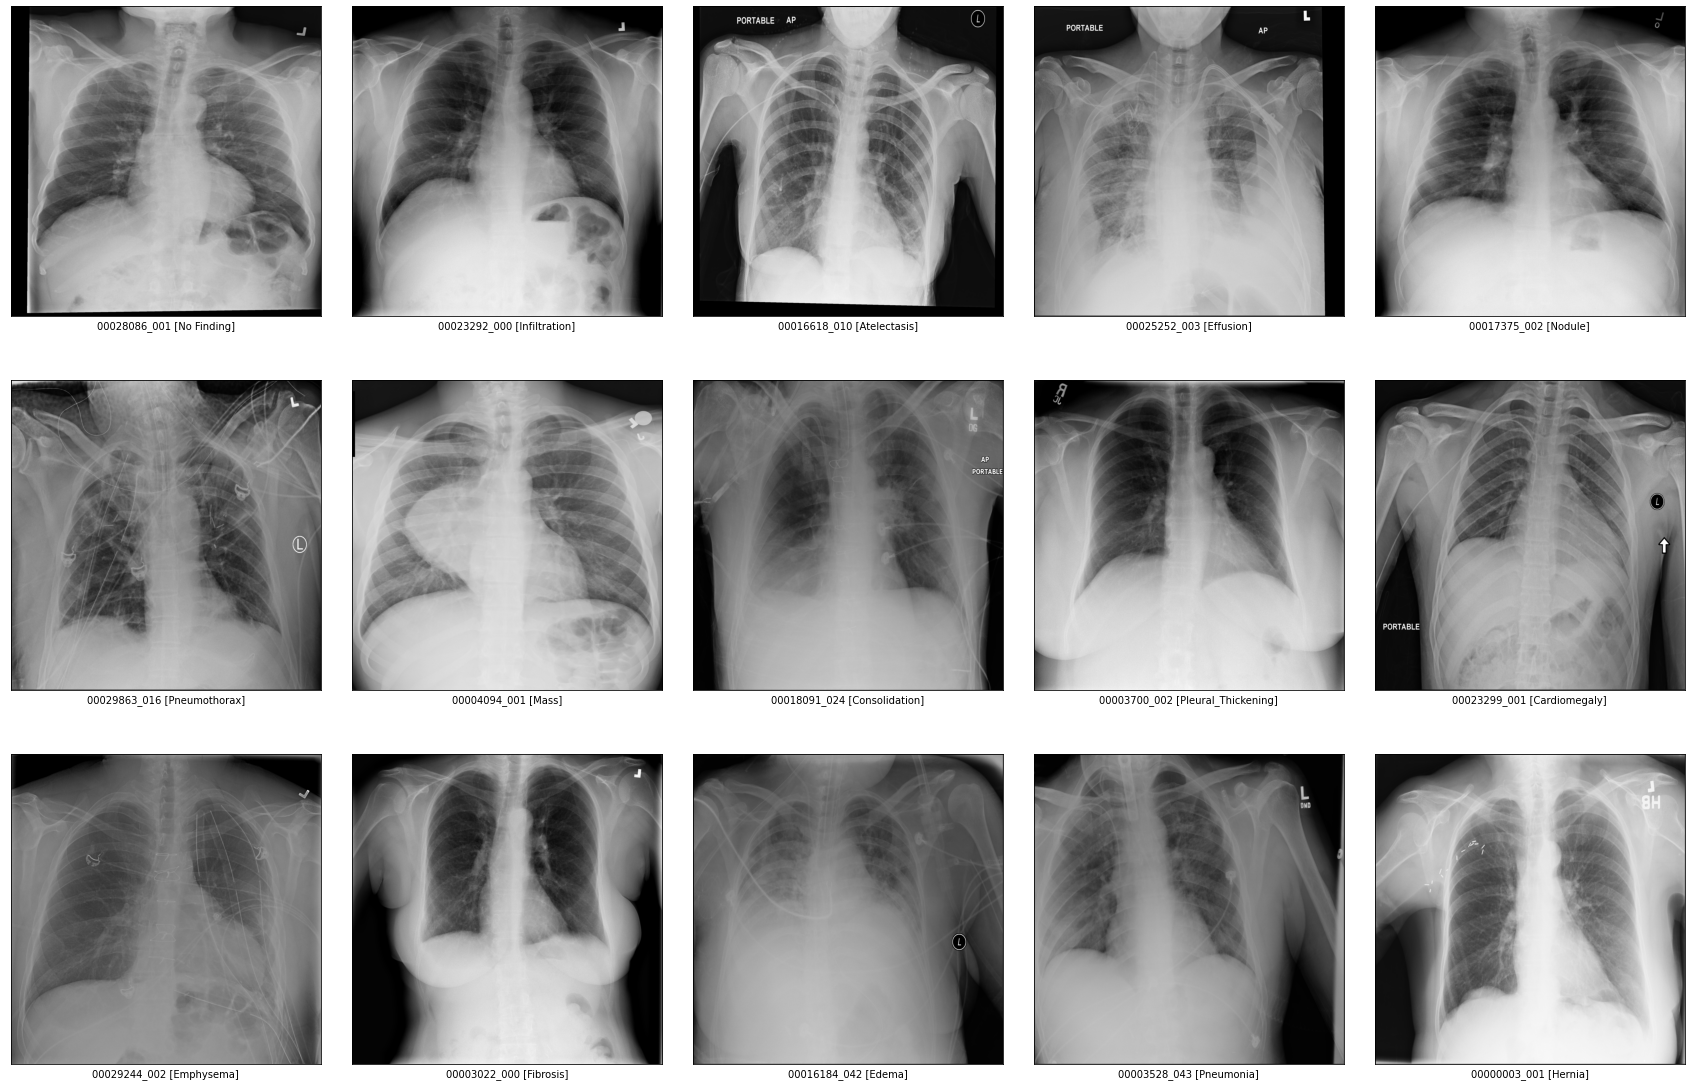

In [12]:
ordered_conditions = singlecond_df[findings].sum(axis=0).sort_values(ascending=False).index.tolist()
ordered_cols = singlecond_df.columns[:len(singlecond_df.columns) - len(findings)].tolist() + ordered_conditions
ordered_df = pd.DataFrame(singlecond_df, columns=ordered_cols)

# outside of workspace as directory is very large
img_dir = "/Data/nih_xray_chest/data/images"
sample_names = [(condition, singlecond_df[singlecond_df[condition] == 1]['Image Index'].iloc[np.random.randint(singlecond_df[condition].sum(axis=0))]) for condition in ordered_conditions]
sample_imgs = [(condition, filename, cv.imread(os.path.join(img_dir, filename))) for (condition, filename) in sample_names]

fig = plt.figure(figsize=(30, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, (condition, filename, img) in enumerate(sample_imgs):
    ax = fig.add_subplot(len(sample_imgs) // 5, 5, i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel("{0} [{1}]".format(filename[:-4], condition))

From the above samples in it clear there is a fair amount of variation in the images.

To reduce this it may be useful to reduce the image set to only include one view position.

In [175]:
ordered_df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

There are only two viewing positions in the dataset, lets see how many occur.

In [193]:
pa_df = ordered_df[ordered_df['View Position'] == 'PA']
ap_df = ordered_df[ordered_df['View Position'] == 'AP']

print(f"Full : {len(ordered_df)}")
print(f"PA   : {len(pa_df)} ({100*len(pa_df)/len(ordered_df):.0f}%)")
print(f"AP   : {len(ap_df)} ({100*len(ap_df)/len(ordered_df):.0f}%)")

Full : 91324
PA   : 57130 (63%)
AP   : 34194 (37%)


Lets view some samples to see the difference.

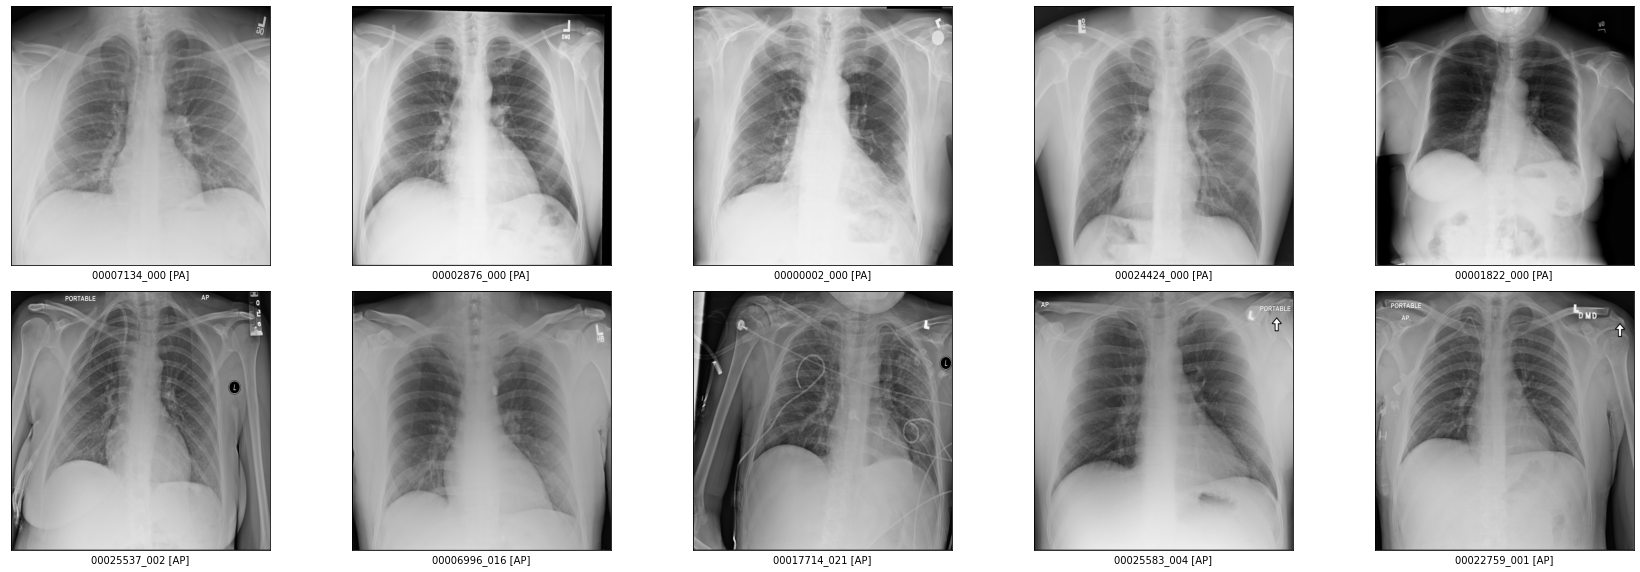

In [211]:
num = 5

pa_nocond_df = pa_df[pa_df['No Finding'] == 1]
ap_nocond_df = ap_df[ap_df['No Finding'] == 1]
pa_names = [pa_nocond_df['Image Index'].iloc[idx] for idx in np.random.choice(len(pa_nocond_df), num)]
ap_names = [ap_nocond_df['Image Index'].iloc[idx] for idx in np.random.choice(len(ap_nocond_df), num)]
pa_samples = [(filename, cv.imread(os.path.join(img_dir, filename))) for filename in pa_names]
ap_samples = [(filename, cv.imread(os.path.join(img_dir, filename))) for filename in ap_names]

fig = plt.figure()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, ((pa_filename, pa_img), (ap_filename, ap_img)) in enumerate(zip(pa_samples, ap_samples)):
    # PA viewing position samples
    ax = fig.add_subplot(2, num, i + 1)
    ax.imshow(pa_img, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel("{0} [PA]".format(pa_filename[:-4]))
    # AP viewing position samples
    ax = fig.add_subplot(2, 5, i + num + 1)
    ax.imshow(ap_img, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel("{0} [AP]".format(ap_filename[:-4]))